# Shopper similarity analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Theory

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image

## Import raw data

In [4]:
signal_df = utils.import_signals('Mall of Mauritius', version=3, signal_type=1)

## Method

We want to investigate whether there are any similarities in which shop the shoppers go to. Using network analysis, create a matrix which has each shopper on the on axis and each shop on another axis. The number of signals recorded for each shoppers will be the value in the matrix.

Using this matrix, we can determine how similar the shoppers are. The new matrix will have the shoppers on both axis and values will contain the number of shops which they both went to. The matrix will be symmetric. This matrix can be analysed in various ways:
- the degree vs the rank (rank distribution)
- number of clusters

## Get data

In [127]:
clean_signal_df = signal_df[signal_df.store_id.notnull()]
shopper_shop_pivot = pd.pivot_table(clean_signal_df, values='x', index='mac_address', columns='store_id', aggfunc=len)

In [128]:
shops = shopper_shop_pivot.columns.tolist()
shoppers = shopper_shop_pivot.index.tolist()
shopper_shop_matrix = shopper_shop_pivot.as_matrix()

In [177]:
shopper_shop_matrix = np.nan_to_num(shopper_shop_matrix, 0)
shopper_shop_matrix[np.where(shopper_shop_matrix > 0)] = 1
np.max(np.sum(shopper_shop_matrix, axis=1))

130.0

In [168]:
count_sort = np.sort(np.sum(shopper_shop_matrix, axis=1))

## Number of people in each shop

In [ ]:
create_count_of_shoppers_image(count_of_shoppers, frame_times, count_index=60)

The number of people in each shop of `Mall of Mauritius` at the beginning of the day. The area of the dots (number of people) are largest around the entrances, the major shops (Intermart) and major hallways. Fewer people are in the smaller shops.

Issues:
- Some dots are very close to other dots (in the same shop). This might be caused by a shop with two floors and will need further investigating.

### Create GIF of the number of people in each shop over time

In [ ]:
%%capture
create_count_of_shoppers_gif(count_of_shoppers, frame_times)

## In-Degree Ranked Distribution

The in-degree, $k_{in}$, is the sum of the adjancency matrix elements that direct to a particular shop i.e. how many people go into a particular shop. 

$$ k_{in} = \sum_{j} A_{ij}. $$


Asumming that every shop starts and ends with no people in it, $k_{in}$ is equal to the total number of people that visit a particular shop (count the number of devices that have emitted a signal in each shop). 

$$ k_{in} = \text{number of people that visit the shop}. $$

There are only 100 shops therefore the degree distribution will not produce an insightful plot (because most degrees will only occur once). Use a ranked distribution (Zipf plot) instead which calculates the rank, $r_{i}$, 

$$ r_{i} = N \sum_{k=k_{i}}^{\infty}P(k), $$

where N is the number of observed degrees.

### Results

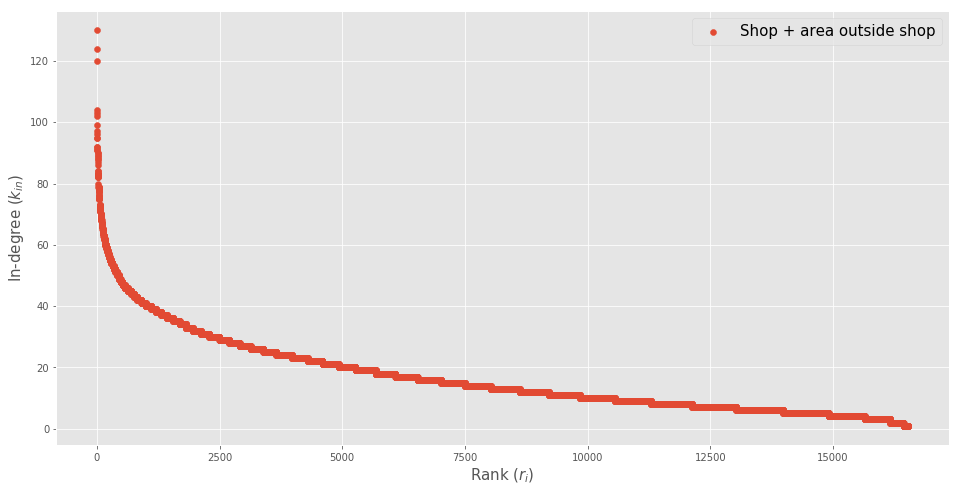

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

degrees, rank = count_sort, range(len(count_sort))[::-1]
plt.scatter(rank, degrees, label='Shop + area outside shop')

# ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('Rank ($r_{i}$)', fontsize=15)
ax.set_ylabel('In-degree ($k_{in}$)', fontsize=15);
ax.legend(loc='best', fontsize=15);

The rank distribution (Zipf Plot) showing the in-degree ($k_{in}$) against the in-degree rank $r_{i}$. The in-degree is the number of people that were in that shop over the day and the rank is the position in the frequency table. Therefore, shops that recieve looks of people (left side of graph) have a low rank because there is a lower probability of these types of show. On the other hand, there are lots of shops (high rank) that have few people (low $k_{in}$).

## Further Network Research

**Measures**

- More rank distribution (what does it look like for stationary devices
- Next shop vs distance from the shop
- Use every centrality measure
- 